<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Amazon-Food-w/-Graphwave" data-toc-modified-id="Amazon-Food-w/-Graphwave-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Amazon Food w/ Graphwave</a></span><ul class="toc-item"><li><span><a href="#Using-only-T-1-embedding" data-toc-modified-id="Using-only-T-1-embedding-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Using only T-1 embedding</a></span></li><li><span><a href="#Pure-Sum" data-toc-modified-id="Pure-Sum-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Pure Sum</a></span></li><li><span><a href="#Expotential-Sum" data-toc-modified-id="Expotential-Sum-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Expotential Sum</a></span></li></ul></li><li><span><a href="#Amazon-Food-Monthly-Equal" data-toc-modified-id="Amazon-Food-Monthly-Equal-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Amazon Food Monthly Equal</a></span><ul class="toc-item"><li><span><a href="#Using-only-T-1-Embedding" data-toc-modified-id="Using-only-T-1-Embedding-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Using only T-1 Embedding</a></span></li><li><span><a href="#Pure-Sum" data-toc-modified-id="Pure-Sum-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Pure Sum</a></span></li><li><span><a href="#Exponential-Sum" data-toc-modified-id="Exponential-Sum-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Exponential Sum</a></span></li></ul></li><li><span><a href="#Reddit-Equal" data-toc-modified-id="Reddit-Equal-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Reddit Equal</a></span><ul class="toc-item"><li><span><a href="#Using-only-T-1-Embedding" data-toc-modified-id="Using-only-T-1-Embedding-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Using only T-1 Embedding</a></span></li><li><span><a href="#Pure-Sum" data-toc-modified-id="Pure-Sum-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Pure Sum</a></span></li><li><span><a href="#Exponential-Sum" data-toc-modified-id="Exponential-Sum-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Exponential Sum</a></span></li></ul></li></ul></div>

In [1]:
%matplotlib inline
import networkx as nx 
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import graphwave
from graphwave.shapes import build_graph
from graphwave.graphwave import *
import pickle

import random
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
import seaborn as sns
sns.set_style('darkgrid')

%load_ext autoreload
%autoreload 2
np.random.seed(123)


In [11]:
def edge_features(node_emb_1, node_emb_2, operator):
    
    # combine two nodes' embeddings with specificed operator
    if operator == 'Average':
        edge = [((x + y) / 2.0) for x,y in zip(node_emb_1, node_emb_2)]
    elif operator == 'Hadamard':
        edge = [(x * y) for x,y in zip(node_emb_1, node_emb_2)]
    elif operator == 'Weighted-L1':
        edge = [abs(x - y) for x,y in zip(node_emb_1, node_emb_2)]
    elif operator == 'Weighted-L2':
        edge = [abs(x - y)**2 for x,y in zip(node_emb_1, node_emb_2)]
    elif operator == 'Concat':
        edge = np.concatenate((node_emb_1, node_emb_2), axis=None) 
    else:
        print("Generate edge features: Operator not supported")
        print("Use default operator: Weighted-L1")
        edge = [abs(x - y) for x,y in zip(node_emb_1, node_emb_2)]
        
    return edge
def generate_edge_features(edge_list, node_embeddings, operator):
    edge_features_mtx = []
    
    # generate features for each edge in the list
    for node_index_1, node_index_2 in edge_list:
        node_emb_1 = node_embeddings[node_index_1]
        node_emb_2 = node_embeddings[node_index_2]
        
        edge_features_mtx.append(edge_features(node_emb_1, node_emb_2, operator))
        
    return edge_features_mtx

def generate_train_set(graph_train, num_edge_sample, node_embeddings, edge_operator,):
    edge_list = list(graph_train.edges)
    num_nodes = graph_train.number_of_nodes()
    
    train_edges = []
    train_edges_labels = [1] * num_edge_sample + [0] * num_edge_sample
    
    random.seed(0)
    
    # sample edges with label 1 (true edges)
    for edge_num in range(num_edge_sample):
        rand_index = random.randint(0, len(edge_list) - 1)
        
        #train_edges.append(tuple(edge_list[rand_index]))
        train_edges.append(edge_list[rand_index])
    non_edge_num = 0
    
    # sample edges with label 0 (non-exist edges)
    while(non_edge_num < num_edge_sample):
        rand_nodes = tuple(np.random.randint(low=0,high=num_nodes, size=2))
        
        if rand_nodes not in edge_list:
            train_edges.append(rand_nodes)
            non_edge_num += 1

    train_edges_features_mtx = generate_edge_features(train_edges, node_embeddings, edge_operator)
            
    return train_edges, train_edges_features_mtx, train_edges_labels

def generate_test_set(graph_test, node_embeddings, edge_operator):
    edge_list = graph_test.edges
    nodes_with_edge = set()
    
    for edge in edge_list:
        nodes_with_edge.add(edge[0])
        nodes_with_edge.add(edge[1])
    
    num_nodes = graph_test.number_of_nodes()
    
    test_edges = []
    test_edges_labels = []
    
    num_edge_sample = len(edge_list)
    non_edge_num = 0 
    # sample edges with label 0 (non-exist edges)
    
    while(non_edge_num < num_edge_sample):
        rand_nodes = tuple(np.random.randint(low=0,high=num_nodes, size=2))
        
        if rand_nodes not in edge_list:
            test_edges.append(rand_nodes)
            test_edges_labels.append(0)
            non_edge_num += 1
        
    for edge in edge_list:
        test_edges.append(edge)
        test_edges_labels.append(1)
    '''
    # generate all possible edges for each node with at least one edge (assume undirected edges)
    for node_1 in nodes_with_edge:
        for node_2 in range(num_nodes):
            test_edges.append((node_1, node_2))
            
            if (node_1, node_2) in edge_list:
                test_edges_labels.append(1)
            else:
                test_edges_labels.append(0)
    '''
    test_edges_features_mtx = generate_edge_features(test_edges, node_embeddings, edge_operator)
    
    return test_edges, test_edges_features_mtx, test_edges_labels

def build_clf(feature_mtx, response_vec):
   
    logistic_regression_model = LogisticRegression(random_state = 0,max_iter=5000,solver='liblinear',verbose=1,tol=1e-6)
    binary_clf = logistic_regression_model.fit(feature_mtx, response_vec)
    
    return binary_clf

def pred_links(feature_mtx, LR_clf):
    predict_edges_labels = LR_clf.predict(feature_mtx)
    
    return predict_edges_labels

def precision_recall(predict_labels, true_labels):
    true_positive  = false_positive = 0
    true_negative =  false_negative = 0
    
    for p_label, true_label in zip(predict_labels, true_labels):
        
        #print(p_label,true_label)
        if p_label == true_label and true_label == 1:
            true_positive += 1
        elif p_label == true_label and true_label == 0:
            true_negative += 1
        elif p_label != true_label and true_label == 1:
            false_negative += 1
        elif p_label != true_label and true_label == 0:
            false_positive += 1

    print("TP: ", true_positive)
    print("TN: ", true_negative)
    print("FP: ", false_positive)
    print("FN: ", false_negative)
    
    try:
        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)
        f1 = 2 * (precision * recall) / (precision + recall)
        print("F1: {}".format(f1))
    except:
        print("F1: Error")
    
    cm = metrics.confusion_matrix(true_labels, predict_labels)
    print(cm)
    print(metrics.classification_report(true_labels, predict_labels))
    map = metrics.average_precision_score(true_labels, predict_labels)
    print('Mean Average Precision: {}'.format(map))
    fpr, tpr, thresholds = metrics.roc_curve(true_labels, predict_labels)
    roc_auc = metrics.auc(fpr, tpr)
    print('Area Under ROC Curve: {}'.format(roc_auc))
    
    
    return

## Amazon Food w/ Graphwave

In [3]:
#load the graphs 
with open('/z/pujat/576/data/amazon_food/amazon_food_monthly_dir.pkl', 'rb') as file:
    graphs = pickle.load(file)
print(len(graphs))
graph_train = graphs[-2]
graph_test = graphs[-1]

120


In [5]:
graphs = graphs[-20:] #only interested in the last 20 monthly snapshots

In [6]:
chi_list = []
heat_print_list = []
taus_list = []
for e, g in enumerate(graphs[:-1]): #last embedding used for link prediction
    chi, heat_print, taus = graphwave_alg(g, np.linspace(0,128,50), taus='auto', verbose=True)
    chi_list.append(chi)
    heat_print_list.append(heat_print)
    taus_list.append(taus)
    print("Completed: {}/{}".format(e,len(graphs[:-1])))

Completed: 0/19
Completed: 1/19
Completed: 2/19
Completed: 3/19
Completed: 4/19
Completed: 5/19
Completed: 6/19
Completed: 7/19
Completed: 8/19
Completed: 9/19
Completed: 10/19
Completed: 11/19
Completed: 12/19
Completed: 13/19
Completed: 14/19
Completed: 15/19
Completed: 16/19
Completed: 17/19
Completed: 18/19


### Using only T-1 embedding

([array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0., 23394.]),
  array([23394.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
        

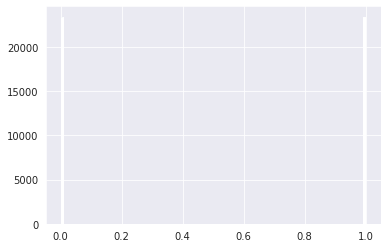

In [27]:
plt.hist(chi_list[-1],bins=100)

In [7]:
num_edge_sample = 400
edge_operator = 'Average' #'Average', 'Average' or 'Hadamard' or 'Weighted-L1' or 'Weighted-L2'
train_edges, train_edges_features_mtx, train_edges_labels = generate_train_set(graph_train, num_edge_sample, chi_list[-2], edge_operator)
test_edges, test_edges_features_mtx, test_edges_labels = generate_test_set(graph_test, chi_list[-1], edge_operator)

In [19]:
for edge_operator in ['Average','Hadamard','Weighted-L1','Weighted-L2','Concat']:
    train_edges, train_edges_features_mtx, train_edges_labels = generate_train_set(graph_train, num_edge_sample, chi_list[-2], edge_operator)
    test_edges, test_edges_features_mtx, test_edges_labels = generate_test_set(graph_test, chi_list[-1], edge_operator)

    LR_clf = build_clf(train_edges_features_mtx, train_edges_labels)

    print("Edge Operator: {}".format(edge_operator))
    predict_edges_labels = pred_links(test_edges_features_mtx, LR_clf)
    precision_recall(list(predict_edges_labels), list(test_edges_labels))


[LibLinear]Edge Operator: Average
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Hadamard
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Weighted-L1
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Weighted-L2
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Concat
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Pure Sum

In [14]:
prev_embedding = np.sum(np.asarray(chi_list[0:-1]),axis=0)
cur_embedding = np.sum(np.asarray(chi_list),axis=0)

In [28]:
num_edge_sample = 400
#Average' or 'Hadamard' or 'Weighted-L1' or 'Weighted-L2'
train_edges, train_edges_features_mtx, train_edges_labels = generate_train_set(graph_train, num_edge_sample, prev_embedding, edge_operator)
test_edges, test_edges_features_mtx, test_edges_labels = generate_test_set(graph_test, cur_embedding, edge_operator)
for edge_operator in ['Average','Hadamard','Weighted-L1','Weighted-L2','Concat']:
    train_edges, train_edges_features_mtx, train_edges_labels = generate_train_set(graph_train, num_edge_sample, prev_embedding, edge_operator)
    test_edges, test_edges_features_mtx, test_edges_labels = generate_test_set(graph_test, cur_embedding, edge_operator)

    LR_clf = build_clf(train_edges_features_mtx, train_edges_labels)

    print("Edge Operator: {}".format(edge_operator))
    predict_edges_labels = pred_links(test_edges_features_mtx, LR_clf)
    precision_recall(list(predict_edges_labels), list(test_edges_labels))
    

[LibLinear]Edge Operator: Average
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Hadamard
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Weighted-L1
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Weighted-L2
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Concat
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Expotential Sum 

In [29]:
embeddings = chi_list
num_edge_sample = 400
#Average' or 'Hadamard' or 'Weighted-L1' or 'Weighted-L2'
for decay in [1,0.9,0.5,0.3]:
    print("------------ BEGIN: {} ---------------".format(decay))
    exps = [math.pow(math.e , (-i * decay)) for i in range(1,len(embeddings[:-2]))]
    exps.reverse()
    temp_embedding = np.zeros((embeddings[0]).shape) 
    for c,e in zip(embeddings[0:-2],exps):
         temp_embedding += e * c 
    prev_embedding = temp_embedding + embeddings[-2]
    
    # this is done so the last embedding has weight one. 
    cur_embedding = temp_embedding + exps[-1] * embeddings[-2] + embeddings[-1]
    
    for edge_operator in ['Average','Hadamard','Weighted-L1','Weighted-L2','Concat']:
        try:
            train_edges, train_edges_features_mtx, train_edges_labels = generate_train_set(graph_train, num_edge_sample, prev_embedding, edge_operator)
            test_edges, test_edges_features_mtx, test_edges_labels = generate_test_set(graph_test, cur_embedding, edge_operator)

            LR_clf = build_clf(train_edges_features_mtx, train_edges_labels)

            print("Edge Operator: {}".format(edge_operator))
            predict_edges_labels = pred_links(test_edges_features_mtx, LR_clf)
            precision, recall = precision_recall(list(predict_edges_labels), list(test_edges_labels))
            print('Precision: ', precision)
            print('Recall: ', recall)
        except:
            print("Edge Operator: {} ERROR".format(edge_operator))
    print("------------ END: {} ---------------".format(decay))


------------ BEGIN: 1 ---------------
[LibLinear]Edge Operator: Average
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
Edge Operator: Average ERROR


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Hadamard
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
Edge Operator: Hadamard ERROR


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Weighted-L1
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
Edge Operator: Weighted-L1 ERROR


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Weighted-L2
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
Edge Operator: Weighted-L2 ERROR


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Concat
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
Edge Operator: Concat ERROR
------------ END: 1 ---------------
------------ BEGIN: 0.9 ---------------


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Average
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
Edge Operator: Average ERROR


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Hadamard
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
Edge Operator: Hadamard ERROR


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Weighted-L1
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Edge Operator: Weighted-L1 ERROR
[LibLinear]Edge Operator: Weighted-L2
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
Edge Operator: Weighted-L2 ERROR


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Concat
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
Edge Operator: Concat ERROR
------------ END: 0.9 ---------------
------------ BEGIN: 0.5 ---------------


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Average
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
Edge Operator: Average ERROR


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Hadamard
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
Edge Operator: Hadamard ERROR


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Weighted-L1
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
Edge Operator: Weighted-L1 ERROR


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Weighted-L2
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
Edge Operator: Weighted-L2 ERROR


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Concat
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
Edge Operator: Concat ERROR
------------ END: 0.5 ---------------
------------ BEGIN: 0.3 ---------------


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Average
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
Edge Operator: Average ERROR


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Hadamard
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
Edge Operator: Hadamard ERROR


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Weighted-L1
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
Edge Operator: Weighted-L1 ERROR


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Weighted-L2
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
Edge Operator: Weighted-L2 ERROR


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Concat
TP:  0
TN:  2785
FP:  0
FN:  2785
F1: Error
[[2785    0]
 [2785    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2785
           1       0.00      0.00      0.00      2785

    accuracy                           0.50      5570
   macro avg       0.25      0.50      0.33      5570
weighted avg       0.25      0.50      0.33      5570

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
Edge Operator: Concat ERROR
------------ END: 0.3 ---------------


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Amazon Food Monthly Equal

In [30]:
#load the graphs 
with open('/z/pujat/576/data/amazon_food/amazon_food_equal_monthly_dir.pkl', 'rb') as file:
    graphs = pickle.load(file)
graph_train = graphs[-2]
graph_test = graphs[-1]

In [32]:
graphs = graphs[-20:]

In [ ]:
chi_list = []
heat_print_list = []
taus_list = []
for e, g in enumerate(graphs[:-1]): #last embedding used for link prediction
    chi, heat_print, taus = graphwave_alg(g, np.linspace(0,200,50), taus='auto', verbose=True)
    chi_list.append(chi)
    heat_print_list.append(heat_print)
    taus_list.append(taus)
    print("Completed: {}/{}".format(e,len(graphs[:-1])))

Completed: 0/19
Completed: 1/19
Completed: 2/19
Completed: 3/19
Completed: 4/19
Completed: 5/19
Completed: 6/19
Completed: 7/19
Completed: 8/19
Completed: 9/19
Completed: 10/19


### Using only T-1 Embedding

In [35]:
for edge_operator in ['Average','Hadamard','Weighted-L1','Weighted-L2','Concat']:
    try:
        train_edges, train_edges_features_mtx, train_edges_labels = generate_train_set(graph_train, num_edge_sample, chi_list[-2], edge_operator)
        test_edges, test_edges_features_mtx, test_edges_labels = generate_test_set(graph_test, chi_list[-1], edge_operator)

        LR_clf = build_clf(train_edges_features_mtx, train_edges_labels)

        print("Edge Operator: {}".format(edge_operator))
        predict_edges_labels = pred_links(test_edges_features_mtx, LR_clf)
        precision, recall = precision_recall(list(predict_edges_labels), list(test_edges_labels))
        print('Precision: ', precision)
        print('Recall: ', recall)
    except:
        print("Edge Operator: {} ERROR".format(edge_operator))

[LibLinear]Edge Operator: Average
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
Edge Operator: Average ERROR


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Hadamard
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
Edge Operator: Hadamard ERROR


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Weighted-L1
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
Edge Operator: Weighted-L1 ERROR


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Weighted-L2
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
Edge Operator: Weighted-L2 ERROR


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Concat
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
Edge Operator: Concat ERROR


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Pure Sum

In [36]:
prev_embedding = np.sum(np.asarray(chi_list[0:-1]),axis=0)
cur_embedding = np.sum(np.asarray(chi_list),axis=0)

In [38]:
num_edge_sample = 400
#Average' or 'Hadamard' or 'Weighted-L1' or 'Weighted-L2'
train_edges, train_edges_features_mtx, train_edges_labels = generate_train_set(graph_train, num_edge_sample, prev_embedding, edge_operator)
test_edges, test_edges_features_mtx, test_edges_labels = generate_test_set(graph_test, cur_embedding, edge_operator)
for edge_operator in ['Average','Hadamard','Weighted-L1','Weighted-L2']:
    train_edges, train_edges_features_mtx, train_edges_labels = generate_train_set(graph_train, num_edge_sample, prev_embedding, edge_operator)
    test_edges, test_edges_features_mtx, test_edges_labels = generate_test_set(graph_test, cur_embedding, edge_operator)

    LR_clf = build_clf(train_edges_features_mtx, train_edges_labels)

    print("Edge Operator: {}".format(edge_operator))
    predict_edges_labels = pred_links(test_edges_features_mtx, LR_clf)
    precision_recall(list(predict_edges_labels), list(test_edges_labels))
    

[LibLinear]Edge Operator: Average
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Hadamard
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Weighted-L1
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Weighted-L2
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Exponential Sum

In [39]:
embeddings = chi_list
num_edge_sample = 400
#Average' or 'Hadamard' or 'Weighted-L1' or 'Weighted-L2'
for decay in [1,0.9,0.5,0.3]:
    print("------------ BEGIN: {} ---------------".format(decay))
    exps = [math.pow(math.e , (-i * decay)) for i in range(1,len(embeddings[:-2]))]
    exps.reverse()
    temp_embedding = np.zeros((embeddings[0]).shape) 
    for c,e in zip(embeddings[0:-2],exps):
         temp_embedding += e * c 
    prev_embedding = temp_embedding + embeddings[-2]
    
    # this is done so the last embedding has weight one. 
    cur_embedding = temp_embedding + exps[-1] * embeddings[-2] + embeddings[-1]
    
    for edge_operator in ['Average','Hadamard','Weighted-L1','Weighted-L2']:
        try:
            train_edges, train_edges_features_mtx, train_edges_labels = generate_train_set(graph_train, num_edge_sample, prev_embedding, edge_operator)
            test_edges, test_edges_features_mtx, test_edges_labels = generate_test_set(graph_test, cur_embedding, edge_operator)

            LR_clf = build_clf(train_edges_features_mtx, train_edges_labels)

            print("Edge Operator: {}".format(edge_operator))
            predict_edges_labels = pred_links(test_edges_features_mtx, LR_clf)
            precision_recall(list(predict_edges_labels), list(test_edges_labels))
            
        except:
            print("Edge Operator: {} ERROR".format(edge_operator))
    print("------------ END: {} ---------------".format(decay))


------------ BEGIN: 1 ---------------
[LibLinear]Edge Operator: Average
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Hadamard
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Weighted-L1
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Weighted-L2
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
------------ END: 1 ---------------
------------ BEGIN: 0.9 ---------------


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Average
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Hadamard
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Weighted-L1
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Weighted-L2
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
------------ END: 0.9 ---------------
------------ BEGIN: 0.5 ---------------


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Average
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Hadamard
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Weighted-L1
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Weighted-L2
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
------------ END: 0.5 ---------------
------------ BEGIN: 0.3 ---------------


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Average
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Hadamard
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Weighted-L1
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]Edge Operator: Weighted-L2
TP:  0
TN:  630
FP:  0
FN:  630
F1: Error
[[630   0]
 [630   0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       630
           1       0.00      0.00      0.00       630

    accuracy                           0.50      1260
   macro avg       0.25      0.50      0.33      1260
weighted avg       0.25      0.50      0.33      1260

Mean Average Precision: 0.5
Area Under ROC Curve: 0.5
------------ END: 0.3 ---------------


/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Reddit Equal

In [ ]:
#load the graphs 
with open('/z/pujat/576/data/reddit/reddit_equal_monthly_dir.pkl', 'rb') as file:
    graphs = pickle.load(file)
graph_train = graphs[-2]
graph_test = graphs[-1]

In [ ]:
chi_list = []
heat_print_list = []
taus_list = []
for e, g in enumerate(graphs[:-1]): #last embedding used for link prediction
    chi, heat_print, taus = graphwave_alg(g, np.linspace(0,200,50), taus='auto', verbose=True)
    chi_list.append(chi)
    heat_print_list.append(heat_print)
    taus_list.append(taus)
    print("Completed: {}/{}".format(e,len(graphs[:-1])))

### Using only T-1 Embedding

In [ ]:
num_edge_sample = 400
edge_operator = 'Average' #'Average', 'Average' or 'Hadamard' or 'Weighted-L1' or 'Weighted-L2'
train_edges, train_edges_features_mtx, train_edges_labels = generate_train_set(graph_train, num_edge_sample, chi_list[-2], edge_operator)
test_edges, test_edges_features_mtx, test_edges_labels = generate_test_set(graph_test, chi_list[-1], edge_operator)

In [ ]:
for edge_operator in ['Average','Hadamard','Weighted-L1','Weighted-L2']:
    train_edges, train_edges_features_mtx, train_edges_labels = generate_train_set(graph_train, num_edge_sample, chi_list[-2], edge_operator)
    test_edges, test_edges_features_mtx, test_edges_labels = generate_test_set(graph_test, chi_list[-1], edge_operator)

    LR_clf = build_clf(train_edges_features_mtx, train_edges_labels)

    print("Edge Operator: {}".format(edge_operator))
    predict_edges_labels = pred_links(test_edges_features_mtx, LR_clf)
    precision, recall = precision_recall(list(predict_edges_labels), list(test_edges_labels))
    print('Precision: ', precision)
    print('Recall: ', recall)

### Pure Sum

In [ ]:
prev_embedding = np.sum(np.asarray(chi_list[0:-1]),axis=0)
cur_embedding = np.sum(np.asarray(chi_list),axis=0)

In [ ]:
num_edge_sample = 400
#Average' or 'Hadamard' or 'Weighted-L1' or 'Weighted-L2'
train_edges, train_edges_features_mtx, train_edges_labels = generate_train_set(graph_train, num_edge_sample, prev_embedding, edge_operator)
test_edges, test_edges_features_mtx, test_edges_labels = generate_test_set(graph_test, cur_embedding, edge_operator)
for edge_operator in ['Average','Hadamard','Weighted-L1','Weighted-L2']:
    train_edges, train_edges_features_mtx, train_edges_labels = generate_train_set(graph_train, num_edge_sample, prev_embedding, edge_operator)
    test_edges, test_edges_features_mtx, test_edges_labels = generate_test_set(graph_test, cur_embedding, edge_operator)

    LR_clf = build_clf(train_edges_features_mtx, train_edges_labels)

    print("Edge Operator: {}".format(edge_operator))
    predict_edges_labels = pred_links(test_edges_features_mtx, LR_clf)
    precision, recall = precision_recall(list(predict_edges_labels), list(test_edges_labels))
    print('Precision: ', precision)
    print('Recall: ', recall)

### Exponential Sum

In [ ]:
embeddings = chi_list
num_edge_sample = 400
#Average' or 'Hadamard' or 'Weighted-L1' or 'Weighted-L2'
for decay in [1,0.9,0.5,0.3]:
    print("------------ BEGIN: {} ---------------".format(decay))
    exps = [math.pow(math.e , (-i * decay)) for i in range(1,len(embeddings[:-2]))]
    exps.reverse()
    temp_embedding = np.zeros((embeddings[0]).shape) 
    for c,e in zip(embeddings[0:-2],exps):
         temp_embedding += e * c 
    prev_embedding = temp_embedding + embeddings[-2]
    
    # this is done so the last embedding has weight one. 
    cur_embedding = temp_embedding + exps[-1] * embeddings[-2] + embeddings[-1]
    
    for edge_operator in ['Average','Hadamard','Weighted-L1','Weighted-L2']:
        try:
            train_edges, train_edges_features_mtx, train_edges_labels = generate_train_set(graph_train, num_edge_sample, prev_embedding, edge_operator)
            test_edges, test_edges_features_mtx, test_edges_labels = generate_test_set(graph_test, cur_embedding, edge_operator)

            LR_clf = build_clf(train_edges_features_mtx, train_edges_labels)

            print("Edge Operator: {}".format(edge_operator))
            predict_edges_labels = pred_links(test_edges_features_mtx, LR_clf)
            precision, recall = precision_recall(list(predict_edges_labels), list(test_edges_labels))
            print('Precision: ', precision)
            print('Recall: ', recall)
        except:
            print("Edge Operator: {} ERROR".format(edge_operator))
    print("------------ END: {} ---------------".format(decay))
